<a href="https://colab.research.google.com/github/ethanyoum/Tesla/blob/main/EthanYoum_StockProject_RealFinalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tesla Stock Analysis & Prediction Modeling using Deep Learning**

In [ ]:
# Import necessary libraries
import time
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

Check with Some Practices

In [ ]:
# Test with NVIDIA
nvda = yf.download('NVDA', start = '2024-11-11', end = '2024-12-14')
nvda['Date'] = nvda.index
nvda.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Date
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,
2024-11-11,145.249985,148.839749,143.560114,148.669747,182325600,2024-11-11
2024-11-12,148.279770,149.639677,145.999928,146.769879,198634700,2024-11-12
2024-11-13,146.259918,149.319705,145.889933,149.059728,191903300,2024-11-13
2024-11-14,146.749878,148.989729,145.539970,147.629822,194463300,2024-11-14
2024-11-15,141.970215,145.230000,140.070352,144.860015,250132900,2024-11-15


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/data_table.py", line 187, in _repr_mimebundle_
    dataframe = self._preprocess_dataframe()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/colab/data_table.py", line 180, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 6472, in reset_index
    new_obj.insert(
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 5158, in insert
    raise ValueError(f"cannot insert {column}, already exists")
ValueError: cannot insert ('Date', ''), already exists
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/data_table.py", line 199, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
                        ^^^^^^^^^^^^^^^^^^^

In [ ]:
aapl_data = yf.download("AAPL", start = '2023-10-01', end = '2024-12-14')
print(aapl_data.columns)

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [ ]:
# Check Apple's P/E Ratio, P/B Ratio, PEG Ratio respectively as example
aapl = yf.Ticker('AAPL')
pe_ratio = aapl.info['trailingPE']
print(pe_ratio)

pb_ratio = aapl.info['priceToBook']
print(pb_ratio)

peg_ratio = aapl.info.get('pegRatio', None)
print(peg_ratio)

aapl_data = yf.download("AAPL", start = '2023-10-01', end = '2024-12-14', auto_adjust=False)
delta = aapl_data['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

window = 14  # Common period for RSI
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
print(rsi)

[*********************100%***********************]  1 of 1 completed

38.763866
55.114914
None
Ticker           AAPL
Date                 
2023-10-02        NaN
2023-10-03        NaN
2023-10-04        NaN
2023-10-05        NaN
2023-10-06        NaN
...               ...
2024-12-09  96.019715
2024-12-10  96.163014
2024-12-11  90.355378
2024-12-12  92.894975
2024-12-13  92.504660

[304 rows x 1 columns]


In [ ]:
# Add RSI_Classification column to appl_data
aapl_data['RSI_Classification'] = rsi['AAPL'].apply(
    lambda x: "Overestimated" if x > 70 else "Underestimated"
    if x < 30 else "Neutral" if pd.notna(x) else None)

# Display the DataFrame with classifications
print(aapl_data[['RSI_Classification']])

# Check the number of each category
print((aapl_data['RSI_Classification'] == 'Overestimated').sum())
print((aapl_data['RSI_Classification'] == 'Underestimated').sum())
print((aapl_data['RSI_Classification'] == 'Neutral').sum())

Price      RSI_Classification
Ticker                       
Date                         
2023-10-02               None
2023-10-03               None
2023-10-04               None
2023-10-05               None
2023-10-06               None
...                       ...
2024-12-09      Overestimated
2024-12-10      Overestimated
2024-12-11      Overestimated
2024-12-12      Overestimated
2024-12-13      Overestimated

[304 rows x 1 columns]
59
33
199


# **Part 1: Analysis / Visualization**

In [ ]:
# Set up a DataFrame to store results
results = pd.DataFrame(columns=["Financial Indicator", "RSI", "P/E Ratio", "P/B Ratio",
                                "Annualized Volatility", "Classification"])

# RSI calculation
def calculate_rsi(data, window = 14):
    delta = data['Adj Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window = window).mean()
    avg_loss = loss.rolling(window = window).mean()
    rs = avg_gain/avg_loss.replace(0, np.nan)
    rsi = 100 - (100/(1+rs))
    return float(rsi.dropna().iloc[-1]) if not rsi.dropna().empty else None

# PB ratio calculation - PB ratio I used before only reflects average of total records, so need correction
def calculate_PB(stock_price, book_value):
  if book_value > 0:
    return float(stock_price)/float(book_value)
  return None

TSLA_threshold = {
    'TSLA': {
        'PE_low': 50,
        'PE_high': 150,
        'PB_low': 5,
        'PB_high': 15,
        'Volatility': 0.5
    }
}


# Classification
def classify_stock(ticker, PE, PB, volatility):
    threshold = TSLA_threshold.get(ticker, {})

    if not threshold:
      return 'Unknown'

    if PE is None or PB is None or volatility is None:
      return 'Unknown'

    if PE <threshold['PE_low'] and PB < threshold['PB_low']:
      return 'Underpriced'

    elif threshold['PE_low'] <= PE <= threshold['PE_high'] and threshold['PB_low'] <= PB <= threshold["PB_high"] and volatility <= 0.5:
      return 'Well_priced'

    elif PE > threshold["PE_high"] or PB > threshold["PB_high"] or volatility > 0.5:
      return 'Overpriced'

# 2017/11/14 - 2024/12/14
TSLA = 'TSLA'
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14', auto_adjust=False)

rsi = calculate_rsi(data)
stock = yf.Ticker(TSLA)
info = stock.info
pe_ratio = info.get('trailingPE', None)
book_value = float(info.get('bookValue', None))

if pe_ratio is None or book_value is None:
    print("Missing P/E or Book Value for TSLA.")

stock_price = float(data['Adj Close'].iloc[-1]) if not data.empty else None
pb_ratio = calculate_PB(stock_price, book_value) if book_value else None

data['Daily Return'] = data['Adj Close'].pct_change()
annual_volatility = data['Daily Return'].std() * (252 ** 0.5) if not data.empty else None

# Classify stock
classification = classify_stock(TSLA, pe_ratio, pb_ratio, annual_volatility)

# Add results
new_results = pd.DataFrame([{
            'Financial Indicator': TSLA,
            'RSI': rsi,
            'P/E Ratio': pe_ratio,
            'P/B Ratio': pb_ratio,
            'Annualized Volatility': annual_volatility,
            'Classification': classification
}])
results = pd.concat([results, new_results], ignore_index = True)

results

[*********************100%***********************]  1 of 1 completed
<ipython-input-19-945b260bae2f>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rsi.dropna().iloc[-1]) if not rsi.dropna().empty else None
<ipython-input-19-945b260bae2f>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_price = float(data['Adj Close'].iloc[-1]) if not data.empty else None
<ipython-input-19-945b260bae2f>:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_results], ignore_index = True)


,Financial Indicator,RSI,P/E Ratio,P/B Ratio,Annualized Volatility,Classification
0,TSLA,78.326245,175.29063,19.240914,0.63182,Overpriced


[*********************100%***********************]  1 of 1 completed


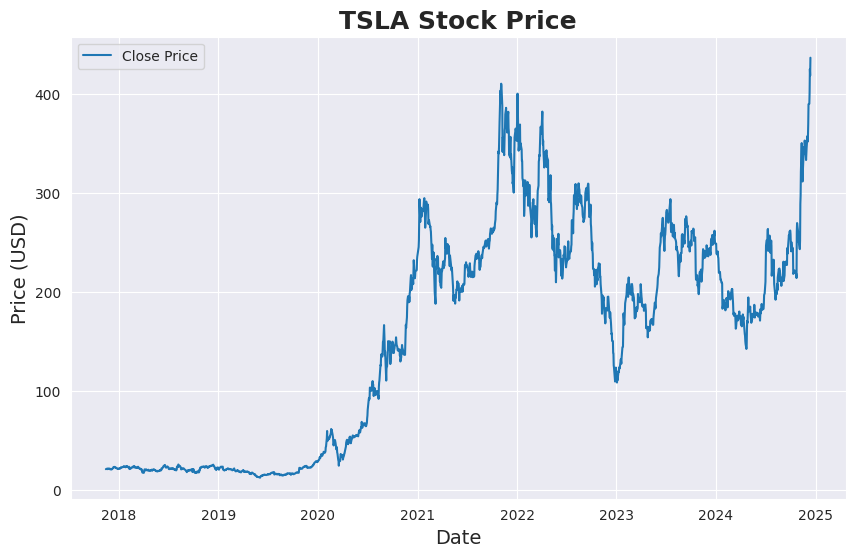

In [ ]:
# Visualization of stock prices from 2017-11-14 to 2024-12-14
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14')
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title("TSLA Stock Price", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


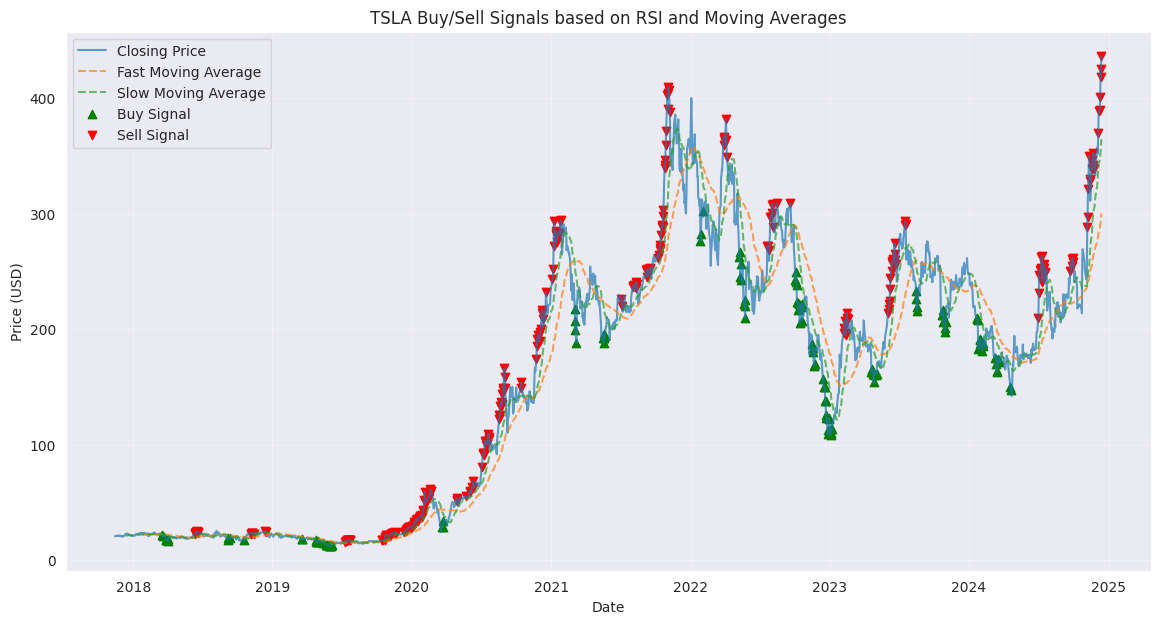

In [ ]:
## Generate Buy/Sell signal with RSI
# Parameters necessary for the signal
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14', auto_adjust=False)
window = 14
slow_moving_period = 20
fast_moving_period = 50
buy_threshold = 30
sell_threshold = 70

# RSI calculation
delta = data['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window = window).mean()
avg_loss = loss.rolling(window = window).mean()
rs = avg_gain/avg_loss.replace(0, np.nan)
rsi = 100 - (100/(1 + rs))

data['RSI'] = rsi

# Initialize the signal
data['signal'] = 0

# Moving averages
data['fast_moving_avg'] = data['Adj Close'].rolling(window = fast_moving_period).mean()
data['slow_moving_avg'] = data['Adj Close'].rolling(window = slow_moving_period).mean()

# Buy/Sell Signals
data.loc[(data['fast_moving_avg'] > data['slow_moving_avg']) & (data['RSI'] < buy_threshold), 'signal'] = 1
data.loc[(data['fast_moving_avg'] < data['slow_moving_avg']) & (data['RSI'] > sell_threshold), 'signal'] = -1

# Filter signals for generating plot
buy_signal = data[data['signal'] == 1]
sell_signal = data[data['signal'] == -1]

# Plot
plt.figure(figsize = (14, 7))
plt.plot(data['Adj Close'], label = 'Closing Price', alpha = 0.7)
plt.plot(data['fast_moving_avg'], label = 'Fast Moving Average', alpha = 0.7, linestyle = '--')
plt.plot(data['slow_moving_avg'], label = 'Slow Moving Average', alpha = 0.7, linestyle = '--')
plt.scatter(buy_signal.index, buy_signal['Adj Close'], label = 'Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signal.index, sell_signal['Adj Close'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('TSLA Buy/Sell Signals based on RSI and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


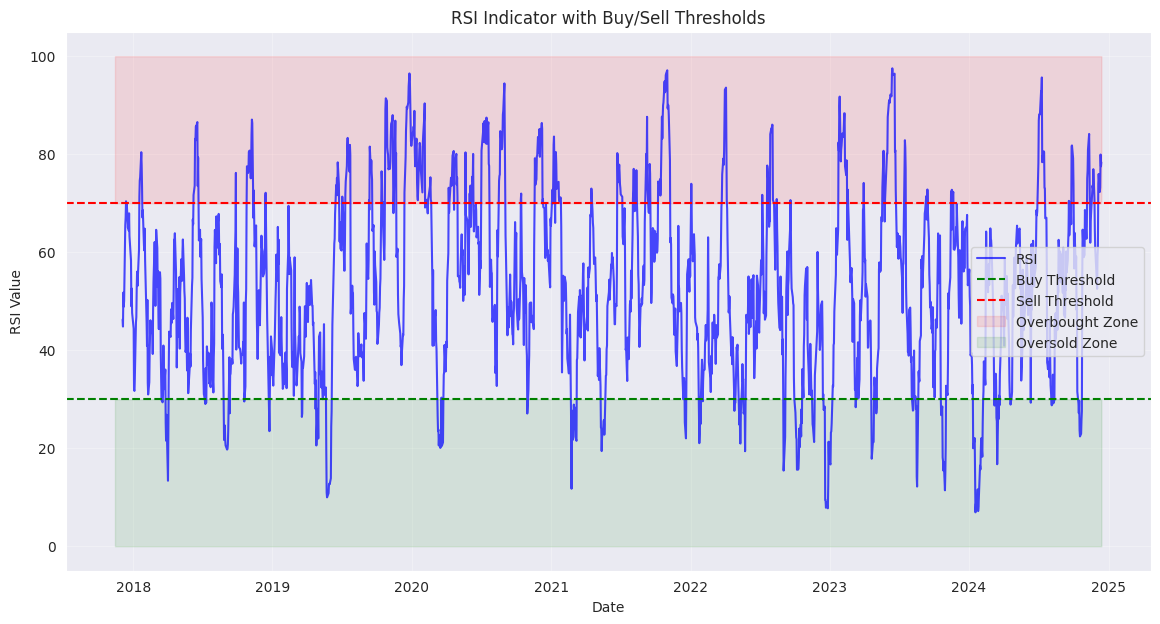

In [ ]:
# Generate the plot of RSI with Buy & Sell Threshold
plt.figure(figsize = (14, 7))
plt.plot(data['RSI'], label = 'RSI', color = 'blue', alpha = 0.7)
plt.axhline(y = buy_threshold, color = 'green', linestyle = '--', label = 'Buy Threshold')
plt.axhline(y = sell_threshold, color = 'red', linestyle = '--', label = 'Sell Threshold')

plt.fill_between(data.index, 70, 100, color = 'red', alpha = 0.1, label = 'Overbought Zone')
plt.fill_between(data.index, 0, 30, color = 'green', alpha = 0.1, label = 'Oversold Zone')

plt.title('RSI Indicator with Buy/Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

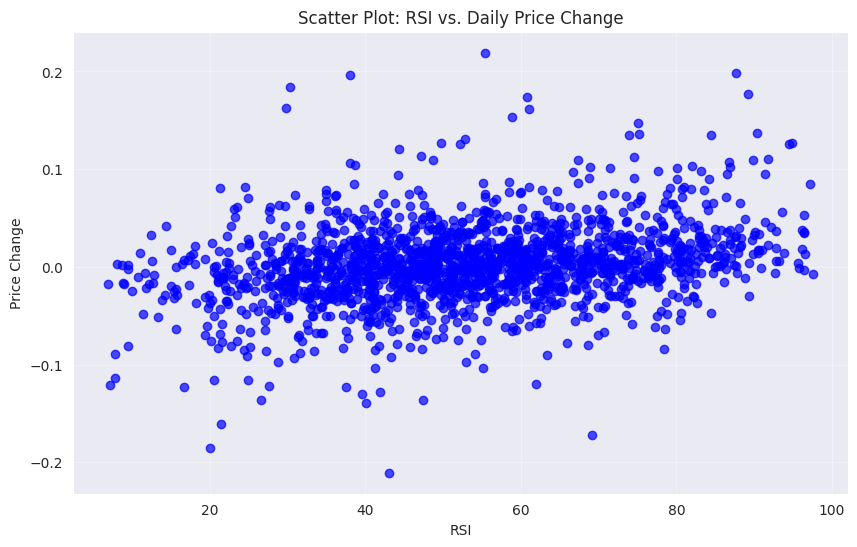

In [ ]:
# Scatter plot of RSI vs Stock Price
data['Daily_Return'] = data['Adj Close'].pct_change()

plt.figure(figsize = (10, 6))
plt.scatter(data['RSI'], data['Daily_Return'], alpha = 0.7, color = 'blue')
plt.title('Scatter Plot: RSI vs. Daily Price Change')
plt.xlabel('RSI')
plt.ylabel('Price Change')
plt.grid(alpha=0.3)
plt.show()


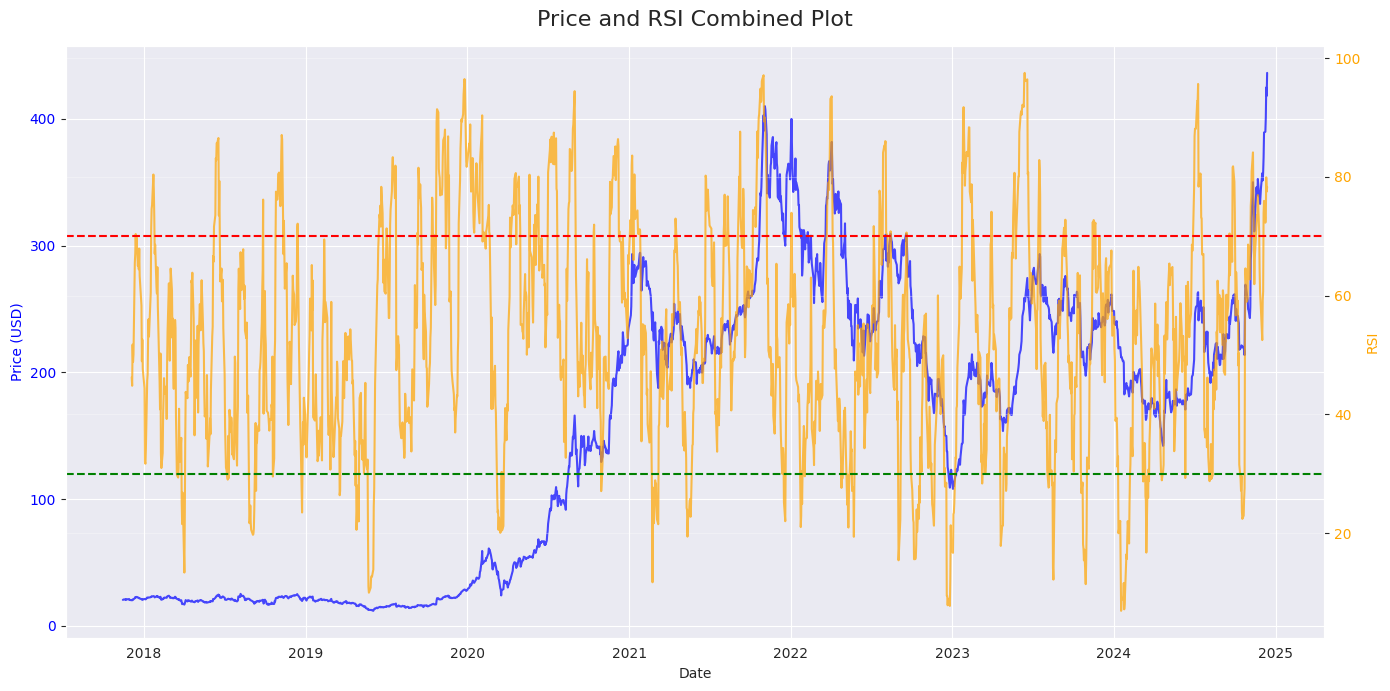

In [ ]:
# Plot with combination of RSI & Price
fig, ax1 = plt.subplots(figsize = (14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.plot(data['Adj Close'], label='Price', color='blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='blue')

# RSI on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('RSI', color='orange')
ax2.plot(data['RSI'], label='RSI', color='orange', alpha=0.7)
ax2.axhline(y=buy_threshold, color='green', linestyle='--', label='Buy Threshold (30)')
ax2.axhline(y=sell_threshold, color='red', linestyle='--', label='Sell Threshold (70)')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Price and RSI Combined Plot', fontsize=16)
fig.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# **Part 2: Prediction Modeling**

# Normalize Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

start_date = datetime(2015, 12, 14)
end_date = datetime(2024, 12, 14)
ticker = 'TSLA'
data = yf.download(ticker, start = start_date, end = end_date, auto_adjust=False)
data['Date'] = data.index
price = data[['Close']]
print(price.info())
scaler = MinMaxScaler(feature_range = (-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2266 entries, 2015-12-14 to 2024-12-13
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, TSLA)  2266 non-null   float64
dtypes: float64(1)
memory usage: 35.4 KB
None



<ipython-input-27-6008f5b275c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))


In [ ]:
def data_split(stock, lookback):
  raw_data = stock.to_numpy()
  data = []

  for index in range(len(raw_data) - lookback):
    data.append(raw_data[index: index + lookback])
  data = np.array(data)
  test_size = int(np.round(0.2*data.shape[0]))
  train_size = data.shape[0] - test_size

  x_train = data[:train_size,:-1,:]
  y_train = data[:train_size,-1,:]
  x_test = data[train_size:,:-1,:]
  y_test = data[train_size:,-1,:]

  return [x_train, y_train, x_test, y_test]

In [ ]:
window = 20 # choose sequence length
x_train, y_train, x_test, y_test = data_split(price, window)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1797, 19, 1)
y_train.shape =  (1797, 1)
x_test.shape =  (449, 19, 1)
y_test.shape =  (449, 1)


In [ ]:
# Transform into tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# *RNN* *Model Construction*

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, hidden):
    r_output, hidden = self.rnn(x, hidden)
    output = self.fc(r_output[:, -1, :])
    return output, hidden

In [ ]:
# Test and check dimensions
test_rnn = RNN(input_dim=1, output_dim=1, hidden_dim=10, num_layers=2)

# Generate evenly spaced, test data pts
test_input= x_train[0:64,:,:]

# test_input = test_data.unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

# Train RNN

In [ ]:
# Define parameters
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2

rnn = RNN(input_dim, output_dim, hidden_dim, num_layers)
print(rnn)

In [ ]:
# Specify Loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [ ]:
# Training
def train_model(model, x_train, y_train, num_epochs):
  start_time = time.time()
  train_losses = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    total_train_losses = 0.0
    hidden = None
    y_train_pred, hidden = model(x_train, hidden)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch', epoch + 1, 'MSE:', loss.item())
    train_losses[epoch] = loss.item()
  training_time = time.time() - start_time
  print('training time: {}'.format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
rnn_train_pred, rnn_train_losses, rnn_training_time = train_model(rnn, x_train, y_train, num_epochs = 100)

In [ ]:
# Inverse transform the values to plot the graph comparing actual vs predicted
predict = pd.DataFrame(scaler.inverse_transform(rnn_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

# Plotting the comparison actual vs predicted
def plot_training_results(predict, original, train_losses, model_name):
    sns.set_style("darkgrid")
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (" + model_name +")" , color='tomato')
    ax.set_title(ticker+' Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Price (USD)", size = 14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=train_losses, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

In [ ]:
plot_training_results(predict, original, rnn_train_losses, 'RNN')

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

def evaluate_model(model,x_test,y_test,y_train,y_train_pred):
  result=[]

  hidden = None
  y_test_pred, hidden = model(x_test, hidden)

  # Invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())

  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:,0], y_train_pred[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:,0], y_test_pred[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  result.append(trainScore)
  result.append(testScore)
  result.append(rnn_training_time)
  return y_test_pred, result

In [ ]:
rnn_test_pred, rnn_result=evaluate_model(rnn,x_test,y_test,y_train,rnn_train_pred)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def predictions_plot(y_train_pred,y_test_pred, model_name):
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())

  # Shift train predictions for plotting
  trainPredictPlot = np.empty_like(price)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[window:len(y_train_pred) + window, :] = y_train_pred

  # Shift test predictions for plotting
  testPredictPlot = np.empty_like(price)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(y_train_pred) + window - 1:len(price) - 1, :] = y_test_pred

  original = scaler.inverse_transform(price['Close'].values.reshape(-1, 1))
  predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
  predictions = np.append(predictions, original, axis = 1)
  result = pd.DataFrame(predictions)

  fig = go.Figure()
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[0],
                    mode='lines',
                    name='Train prediction')))
  fig.add_trace(go.Scatter(x=data['Date'], y=result[1],
                    mode='lines',
                    name='Test prediction'))
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[2],
                    mode='lines',
                    name='Actual Value')))
  fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

  )

  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Tesla Stock Price Change ('+ model_name + ')',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
  fig.update_layout(annotations=annotations)

  fig.show()

In [ ]:
predictions_plot(rnn_train_pred,rnn_test_pred,'RNN')

# *LSTM Model Construction*

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    # Initialize hidden states
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # Shot-term memory
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # Long-term memory

    # Get the outputs and the new hidden state
    out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

    # Put out through the fully-connected layer
    out = self.fc(out[:, -1, :])
    return out


In [ ]:
lstm = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.01)

In [ ]:
print(lstm)

# Train LSTM

In [ ]:
def train_model_lstm(model, x_train, y_train, num_epochs):
  train_losses = np.zeros(num_epochs)
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "MSE: ", loss.item())
    train_losses[epoch] = loss.item()

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time


In [ ]:
lstm_train_pred, lstm_train_losses, lstm_training_time = train_model_lstm(lstm, x_train, y_train, num_epochs = 100)

In [ ]:
predict_lstm = pd.DataFrame(scaler.inverse_transform(lstm_train_pred.detach().numpy()))

In [ ]:
plot_training_results(predict_lstm, original, lstm_train_losses, 'LSTM')

In [ ]:
def evaluation_lstm(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(lstm_training_time)
  return y_test_pred, results

In [ ]:
lstm_test_pred, lstm_result = evaluation_lstm(lstm, x_test, y_test, y_train, lstm_train_pred)

In [ ]:
predictions_plot(lstm_train_pred, lstm_test_pred, 'LSTM')

# *GRU Model Construction*

In [ ]:
class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(GRU, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn) = self.gru(x, (h0.detach()))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
gru = GRU(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr = 0.01)

In [ ]:
print(gru)

# Train GRU

In [ ]:
def train_model_gru(model, x_train, y_train, num_epochs):
  train_losses = np.zeros(num_epochs)
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch + 1, "MSE: ", loss.item())
    train_losses[epoch] = loss.item()

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
gru_train_pred, gru_training_losses, gru_training_time = train_model_gru(gru, x_train, y_train, num_epochs = 100)

In [ ]:
predict_gru = pd.DataFrame(scaler.inverse_transform(gru_train_pred.detach().numpy()))

In [ ]:
plot_training_results(predict_gru, original, gru_training_losses, 'GRU')

In [ ]:
def evaluation_gru(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(gru_training_time)
  return y_test_pred, results

In [ ]:
gru_test_pred, gru_results = evaluation_gru(gru, x_test, y_test, y_train, gru_train_pred)

In [ ]:
predictions_plot(gru_train_pred, gru_test_pred, 'GRU')

In [ ]:
rnn_result_df=pd.DataFrame(rnn_result, columns=['RNN'])
lstm_result_df = pd.DataFrame(lstm_result, columns=['LSTM'])
gru_result_df = pd.DataFrame(gru_results, columns=['GRU'])
result = pd.concat([rnn_result_df,lstm_result_df, gru_result_df], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

# *Customized Model Construction*

In [ ]:
class Customized_model(nn.Module):
  def __init__(self, input_dim, cnn_filters, hidden_dim, num_layers, output_dim):
    super(Customized_model, self).__init__()
    # CNN for feature extraction
    self.conv1 = nn.Conv1d(in_channels = input_dim, out_channels = cnn_filters, kernel_size = 3, padding = 1)
    self.relu = nn.ReLU()
    self.gru = nn.GRU(cnn_filters, hidden_dim, num_layers, batch_first = True)

    # Integrate Bahdanau attention mechanism
    self.attention = nn.Linear(hidden_dim + hidden_dim, hidden_dim)
    self.v = nn.Linear(hidden_dim, 1, bias = False)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.conv1(x.permute(0, 2, 1))
    x = self.relu(x)
    x = x.permute(0, 2, 1)

    gru_out, hidden = self.gru(x)

    hidden = hidden[-1].unsqueeze(1).repeat(1, gru_out.size(1), 1)
    concat = torch.cat((gru_out, hidden), dim = 2)
    attention_scores = torch.tanh(self.attention(concat))
    attention_weights = torch.softmax(self.v(attention_scores).squeeze(-1), dim = 1)
    context_vector = gru_out[:, -1, :]
    context_vector = torch.sum(gru_out * attention_weights.unsqueeze(-1), dim = 1)

    out = self.fc(context_vector)
    return out

In [ ]:
cnn_filters = 16
cm = Customized_model(input_dim = input_dim, cnn_filters = cnn_filters, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cm.parameters(), lr = 0.01)
print(cm)

# Train Customized model

In [ ]:
# Train the Customized model
def train_customized_model(model, x_train, y_train, num_epochs, scheduler = None, patience = 5):
  train_losses = np.zeros(num_epochs)
  best_loss = float('inf')
  epochs_no_improvement = 0
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step(loss)

    train_losses[epoch] = loss.item()

    if loss.item() < best_loss:
      best_loss = loss.item()
      epochs_no_improvement = 0
    else:
      epochs_no_improvement += 1

    print("Epoch ", epoch + 1, "MSE: ", loss.item())

    if epochs_no_improvement >= patience:
      print(f"Early stop triggered after {epoch + 1} epochs")
      break

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 5)

In [ ]:
cm_train_pred, cm_training_losses, cm_training_time = train_customized_model(cm, x_train, y_train, num_epochs = 100, scheduler = scheduler, patience = 5)

In [ ]:
predict_cm = pd.DataFrame(scaler.inverse_transform(gru_train_pred.detach().numpy()))
plot_training_results(predict_cm, original, cm_training_losses, 'CM')

In [ ]:
def evaluation_customized_model(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(gru_training_time)
  return y_test_pred, results

In [ ]:
cm_test_pred, cm_results = evaluation_customized_model(cm, x_test, y_test, y_train, cm_train_pred)

In [ ]:
predictions_plot(cm_train_pred, cm_test_pred, 'CM')

# ***Prediction of the Future Prices***

In [ ]:
# Multi-step prediction using RNN model
def predict_price_rnn(model, recent_data, steps, hidden_dim, num_layers):
  predictions = []
  current_input = recent_data
  hidden = torch.zeros(num_layers, 1, hidden_dim)

  for step in range(steps):
    with torch.no_grad():
      input_tensor = torch.tensor(current_input, dtype = torch.float32).view(1, -1, 1)
      #print(f"Step {step} - Input Tensor Shape: {input_tensor.shape}") # Debugging step
      pred, hidden = model(input_tensor, hidden)
      #print(f"Step {step} - Output Tensor Shape: {pred.shape}") # Debugging step
      predictions.append(pred.item())
      current_input = np.append(current_input[1:], pred.item())
  return predictions

In [ ]:
# Define the parameters
hidden_dim = 32
num_layers = 2
future_steps = 200
recent_data = x_test[-1].numpy()
print(recent_data)

In [ ]:
future_predictions = predict_price_rnn(rnn, recent_data, future_steps, hidden_dim, num_layers)

In [ ]:
# Inverse transform the values
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)
print(future_predictions)